In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prerequisites: Load data

In [ ]:
# set up constants

BASE_GENRES = [
    "genre_blues",
    "genre_classical",
    "genre_country",
    "genre_disco",
    "genre_hiphop",
    "genre_jazz",
    "genre_metal",
    "genre_pop",
    "genre_reggae",
    "genre_rock"
]

STRATIFY = ['stratify']

KEY = ['metadata_path']

In [ ]:
# load base dataframe

import pandas as pd

filepath = "/content/drive/MyDrive/w207/mids_w207_music_genre/member_workspaces/lawrence/mtg_jamendo_genre_features.feather"
df_base = pd.read_feather(filepath)

In [ ]:
# split base data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np


# get features
FEATURES = list(set(df_base.columns) - set(BASE_GENRES) - set(STRATIFY) - set(KEY))
X = df_base[FEATURES]

# get targets
enc = LabelEncoder()
y = enc.fit_transform(df_base[STRATIFY].values.reshape(-1))

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
  
# X_train, X_valid, y_train, y_valid = \
#     train_test_split(X_train, y_train, test_size=0.25, random_state=10, stratify=y_train)

print(F"X_train: {X_train.shape}")
# print(F"X_valid: {X_valid.shape}")
print(F"X_test:  {X_test.shape}")

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
# X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


X_train: (17080, 2739)
X_test:  (4271, 2739)


---

# KNN w/o feature selection

## Experiment \#1: KNN with default parameters

In [ ]:
# Experiment #1: 
# Run logistic regression with default parameters

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

clf = KNeighborsClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

train_accuracy = accuracy_score(y_train, clf.predict(X_train))
# valid_accuracy = accuracy_score(y_valid, clf.predict(X_valid))
test_accuracy = accuracy_score(y_test, clf.predict(X_test))

print(F"Train accuracy: {train_accuracy}")
# print(F"Valid accuracy: {valid_accuracy}")
print(F"Test accuracy:  {test_accuracy}")

Train accuracy: 0.7915105386416862
Test accuracy:  0.6811051276047764


---
# KNN with feature selection

## Experiment \#2: KNN with feature selection via random forest

In [ ]:
"""
Experiment #5
Feature selection via random forest
"""
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, 
                             max_depth=500, 
                             random_state=10)
clf.fit(X_train, y_train)
df_feature_importance = pd.DataFrame({"feature_name": FEATURES, 
                                      "feature_importance": clf.feature_importances_})
df_feature_importance.sort_values(by="feature_importance", ascending=False, inplace=True)

In [ ]:
"""
Try to use the top n features as determined by random forest model
to train a logistic regression model
"""
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

tolerance = 10
top_ns = np.arange(10, 510, 10)
train_accuracies = []
test_accuracies = []

for top_n in top_ns:
  top_features = df_feature_importance.head(top_n)['feature_name'].unique()
  feature_indices = [FEATURES.index(f) for f in top_features]

  clf = KNeighborsClassifier(n_jobs=-1)
  clf.fit(X_train[:, feature_indices], y_train)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train[:, feature_indices]))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test[:, feature_indices]))
  test_accuracies.append(test_accuracy)

  print(F"Using the top {top_n} features from random forest model...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  

  if train_accuracy > test_accuracy:
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  

  print(F"-"*100)

Using the top 10 features from random forest model...
Train accuracy: 0.6380562060889929
Test accuracy:  0.4790447202060407
Overfitting detected!
----------------------------------------------------------------------------------------------------
Using the top 20 features from random forest model...
Train accuracy: 0.639344262295082
Test accuracy:  0.4834933270896746
Overfitting detected!
----------------------------------------------------------------------------------------------------
Using the top 30 features from random forest model...
Train accuracy: 0.6757611241217799
Test accuracy:  0.5385155701240927
Overfitting detected!
----------------------------------------------------------------------------------------------------
Using the top 40 features from random forest model...
Train accuracy: 0.6979508196721311
Test accuracy:  0.5755092484195738
Overfitting detected!
----------------------------------------------------------------------------------------------------
Using the top

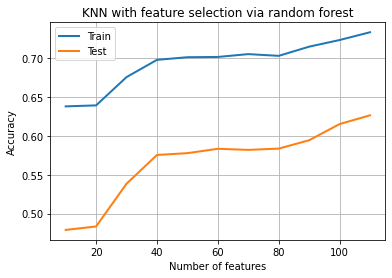

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(top_ns[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(top_ns[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("KNN with feature selection via random forest")
ax.set_xlabel("Number of features")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

---
## Experiment \#3: KNN with feature selection via Select K Best

In [ ]:
"""
Use select K best to select top n features
"""
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

tolerance = 10
top_ns = np.arange(10, 510, 10)
train_accuracies = []
test_accuracies = []

for top_n in top_ns:

  mask_selected_features = np.full((X_train.shape[1], ), False)
  for i in np.unique(y_train):
    skb = SelectKBest(k=top_n)
    mask = y_train == i
    skb.fit(X_train[mask, :], y_train[mask])
    mask_selected_features |= skb.get_support()
    
  X_train_skb = X_train[:, mask_selected_features]
  X_test_skb = X_test[:, mask_selected_features]

  clf = KNeighborsClassifier(n_jobs=-1)
  clf.fit(X_train_skb, y_train)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train_skb))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test_skb))
  test_accuracies.append(test_accuracy)

  print(F"Using the top {top_n} features from select k best...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")

  if train_accuracy > test_accuracy:
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  

  print(F"-"*100)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 10 features from select k best...
Train accuracy: 0.5201990632318502
Test accuracy:  0.31397799110278624
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 20 features from select k best...
Train accuracy: 0.6372365339578454
Test accuracy:  0.4722547412783891
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 30 features from select k best...
Train accuracy: 0.6612997658079626
Test accuracy:  0.5083118707562632
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 40 features from select k best...
Train accuracy: 0.6752341920374707
Test accuracy:  0.5143994380707094
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 50 features from select k best...
Train accuracy: 0.676463700234192
Test accuracy:  0.5331304144228518
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 60 features from select k best...
Train accuracy: 0.6991217798594848
Test accuracy:  0.5450714118473425
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 70 features from select k best...
Train accuracy: 0.7022248243559719
Test accuracy:  0.5598220557246546
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 80 features from select k best...
Train accuracy: 0.7016393442622951
Test accuracy:  0.5687192694919223
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 90 features from select k best...
Train accuracy: 0.7038056206088993
Test accuracy:  0.5745726996019668
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 100 features from select k best...
Train accuracy: 0.7102459016393443
Test accuracy:  0.5663778974479045
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 110 features from select k best...
Train accuracy: 0.7192622950819673
Test accuracy:  0.5773823460547881
Overfitting detected!


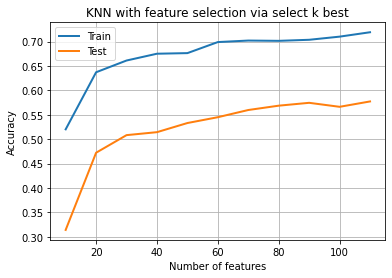

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(top_ns[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(top_ns[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("KNN with feature selection via select k best")
ax.set_xlabel("Number of features")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()



---

# KNN with dimensionality reduction

## Experiment \#4: KNN with PCA

In [ ]:
"""
Use PCA to perform dimensionality reduction
"""

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

tolerance = 10
n_components_list = np.arange(10, 510, 10)
train_accuracies = []
test_accuracies = []

for n_components in n_components_list:

  pca = PCA(n_components)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.transform(X_test)

  clf = KNeighborsClassifier(n_jobs=-1)
  clf.fit(X_train_pca, y_train)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train_pca))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test_pca))
  test_accuracies.append(test_accuracy)

  print(F"Using {n_components} components from PCA...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  print(F"-"*100)

  if train_accuracy > test_accuracy:
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

Using 10 components from PCA...
Train accuracy: 0.6723653395784543
Test accuracy:  0.5364083352844767
----------------------------------------------------------------------------------------------------
Overfitting detected!
----------------------------------------------------------------------------------------------------
Using 20 components from PCA...
Train accuracy: 0.7030444964871194
Test accuracy:  0.5757433856239756
----------------------------------------------------------------------------------------------------
Overfitting detected!
----------------------------------------------------------------------------------------------------
Using 30 components from PCA...
Train accuracy: 0.7252341920374707
Test accuracy:  0.596581596815734
----------------------------------------------------------------------------------------------------
Overfitting detected!
----------------------------------------------------------------------------------------------------
Using 40 components fro

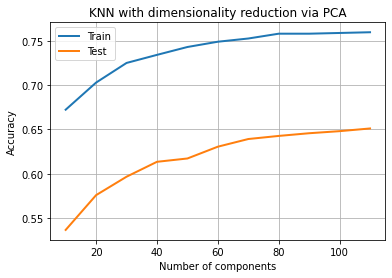

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("KNN with dimensionality reduction via PCA")
ax.set_xlabel("Number of components")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

## Experiment \#5: KNN with kernel PCA

In [ ]:
"""
Use kernel PCA to perform dimensionality reduction
"""

from sklearn.decomposition import KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

tolerance = 10
n_components_list = np.arange(10, 510, 10)
train_accuracies = []
test_accuracies = []

for n_components in n_components_list:

  kpca = KernelPCA(n_components=n_components, 
                   kernel='rbf', 
                   n_jobs=-1, 
                   random_state=10,
                   eigen_solver="randomized")
  X_train_kpca = kpca.fit_transform(X_train)
  X_test_kpca = kpca.transform(X_test)

  clf = KNeighborsClassifier(n_jobs=-1)
  clf.fit(X_train_kpca, y_train)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train_kpca))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test_kpca))
  test_accuracies.append(test_accuracy)

  print(F"Using {n_components} components from kernel PCA...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")

  if train_accuracy > test_accuracy:
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10

  print(F"-"*100)

Using 10 components from kernel PCA...
Train accuracy: 0.6837236533957846
Test accuracy:  0.5492858815265745
Overfitting detected!
----------------------------------------------------------------------------------------------------
Using 20 components from kernel PCA...
Train accuracy: 0.7162763466042155
Test accuracy:  0.5914305783188949
Overfitting detected!
----------------------------------------------------------------------------------------------------
Using 30 components from kernel PCA...
Train accuracy: 0.7290398126463701
Test accuracy:  0.5972840084289394
Overfitting detected!
----------------------------------------------------------------------------------------------------
Using 40 components from kernel PCA...
Train accuracy: 0.7411007025761124
Test accuracy:  0.6160149847810817
Overfitting detected!
----------------------------------------------------------------------------------------------------
Using 50 components from kernel PCA...
Train accuracy: 0.750585480093676

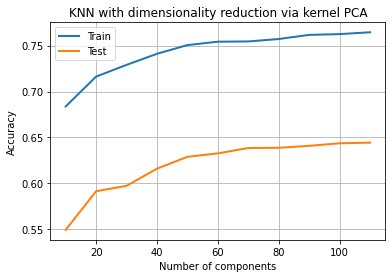

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("KNN with dimensionality reduction via kernel PCA")
ax.set_xlabel("Number of components")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()